# Importing Libraries

In [27]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt



# Loading and Preprocessing Data
Load the dataset and preprocess it by dropping non-relevant columns. Apply Isolation Forest for outlier detection and removal.


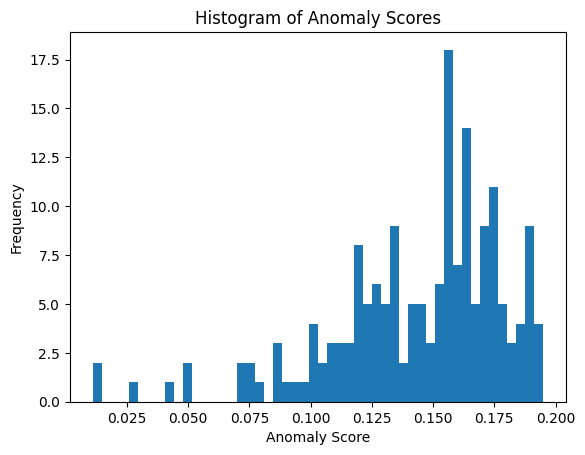

Proportion of observations considered as outliers based on the chosen contamination level: 0.05142857142857143


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Assuming 'aggregated_plants.csv' is your dataset and it's in the correct path
df = pd.read_csv('aggregated_plants.csv')

# Dropping non-relevant columns
df = df.drop(columns=['Plant_Species', 'Reference', 'BitInterpretations'])

# Separating features and target
# Ensure 'Salmonella Typhimurium' is indeed a column and not meant to be the target for IsolationForest which is unsupervised
features = df.drop('Salmonella Typhimurium', axis=1)
target = df['Salmonella Typhimurium']  # This line might not be necessary if you're not using 'target' later

# Fit the model
iso_forest = IsolationForest(random_state=42)
iso_forest.fit(features)

# Compute the anomaly scores (the lower, the more abnormal)
scores = iso_forest.decision_function(features)

# Plot histogram of scores 
plt.hist(scores, bins=50)
plt.title('Histogram of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')

# Save the figure BEFORE calling plt.show()
plt.savefig('charts/anomaly_scores.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Determine the contamination level based on the anomaly scores
contamination_level = np.percentile(scores, 5)

# Calculate the proportion of observations considered as outliers
outlier_proportion = np.mean(scores < contamination_level)

print(f"Proportion of observations considered as outliers based on the chosen contamination level: {outlier_proportion}")


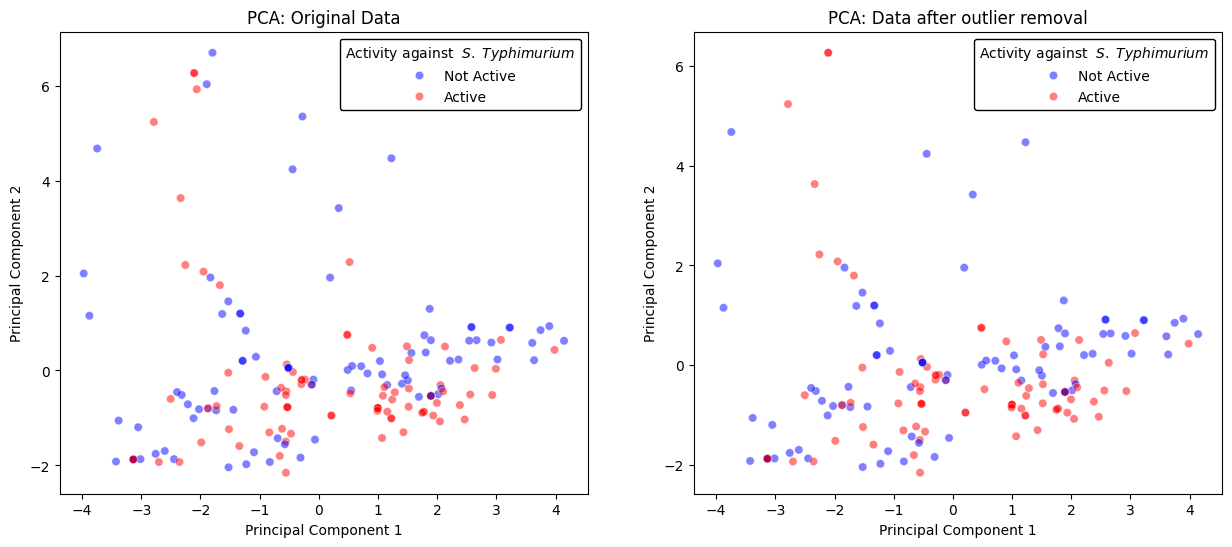

In [2]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt


# Load the dataset
df = pd.read_csv('aggregated_plants.csv')

# Dropping non-relevant columns
df = df.drop(columns=['Plant_Species', 'Reference', 'BitInterpretations'])

# Separating features and target
features = df.drop('Salmonella Typhimurium', axis=1)
target = df['Salmonella Typhimurium']

# Apply PCA for dimensionality reduction for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

# Apply Isolation Forest on original features to detect outliers
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers_pred = iso_forest.fit_predict(features)

# Filter out the outliers based on predictions
features_filtered = features[outliers_pred != -1]
target_filtered = target[outliers_pred != -1]

# Apply PCA on filtered features for visualization
features_filtered_pca = pca.transform(features_filtered)

# Mapping target values to 'Active' and 'Not Active'
activity_labels = pd.Series(target).map({1: 'Active', 0: 'Not Active'}).values
activity_labels_filtered = pd.Series(target_filtered).map({1: 'Active', 0: 'Not Active'}).values

# Plotting
plt.figure(figsize=(15, 6))

# Original Data
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=activity_labels,
                alpha=0.5, palette={'Active': 'red', 'Not Active': 'blue'})
plt.title('PCA: Original Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
legend = ax1.legend(title="Activity against  $\it{S.\ Typhimurium}$", frameon=True, facecolor='white')
legend.get_frame().set_alpha(None)
legend.get_frame().set_edgecolor('black')

# Data After Outlier Removal
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(x=features_filtered_pca[:, 0], y=features_filtered_pca[:, 1], hue=activity_labels_filtered,
                alpha=0.5, palette={'Active': 'red', 'Not Active': 'blue'})
plt.title('PCA: Data after outlier removal')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
legend = ax2.legend(title="Activity against  $\it{S.\ Typhimurium}$", frameon=True, facecolor='white')
legend.get_frame().set_alpha(None)
legend.get_frame().set_edgecolor('black')

# Save the figure
plt.savefig('charts/outlier_detection_result.png', dpi=300, bbox_inches='tight')

plt.show()



# Feature Selection
Use GridSearchCV to find the best parameters for the ExtraTreesClassifier and train the model.


Top features:
1. Bit_875 (0.0309)
2. Bit_549 (0.0248)
3. Bit_1607 (0.0197)
4. Bit_383 (0.0185)
5. Bit_1602 (0.0170)
6. Bit_1750 (0.0164)
7. Bit_1365 (0.0156)
8. Bit_1930 (0.0155)
9. Bit_1853 (0.0153)
10. Bit_1950 (0.0147)
11. Bit_171 (0.0142)
12. Bit_741 (0.0142)
13. Bit_1574 (0.0130)
14. Bit_1309 (0.0129)


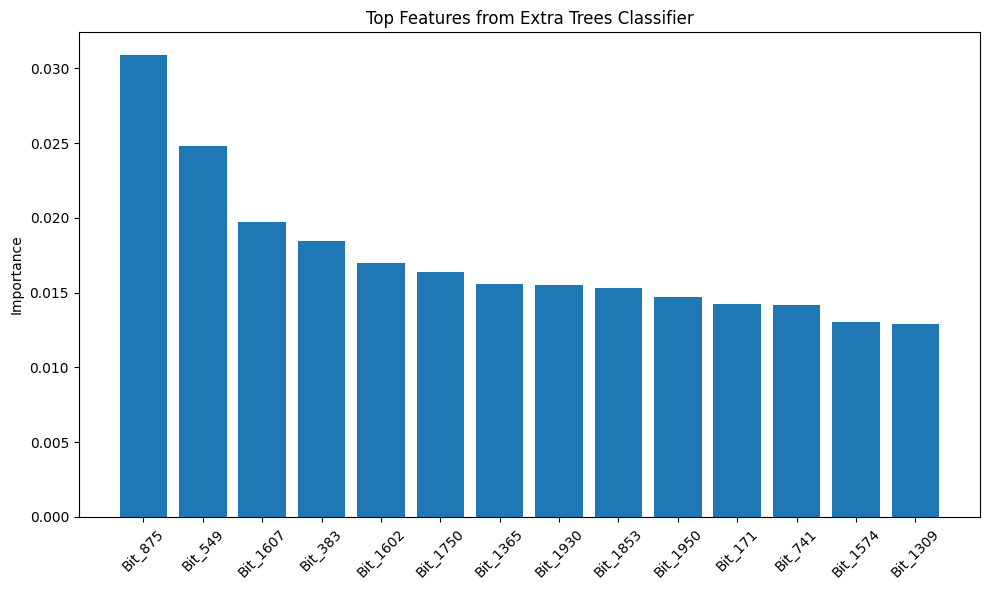

In [50]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score

# Assuming features_filtered and target_filtered have been defined
X_train, X_test, y_train, y_test = train_test_split(features_filtered, target_filtered, test_size=0.2, random_state=42)

# Define the number of top features
TOP_FEATURES = 14

# Use ExtraTreesClassifier to determine feature importances
extra_trees = ExtraTreesClassifier(
    bootstrap=True, 
    criterion='entropy', 
    n_estimators=90,
    min_samples_leaf=2, 
    min_samples_split=4,
    random_state=42
)
extra_trees.fit(X_train, y_train)

importances = extra_trees.feature_importances_
indices = np.argsort(importances)[::-1][:TOP_FEATURES]

# Print top features
print('Top features:')
top_features = [X_train.columns[i] for i in indices]
for f, feature in enumerate(top_features, 1):
    print(f'{f}. {feature} ({importances[indices[f-1]]:.4f})')

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.title('Top Features from Extra Trees Classifier')
plt.bar(range(TOP_FEATURES), importances[indices], align='center')
plt.xticks(range(TOP_FEATURES), [X_train.columns[i] for i in indices], rotation=45)
plt.ylabel('Importance')
plt.tight_layout()
plt.savefig('charts/features_importance.png', dpi=300)
plt.show()

# Selecting the top features for subsequent analysis
X_top_features = X_train[top_features]
y = y_train



# Grid search
Split the dataset into training and testing sets to evaluate the performance of the model.


In [51]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report


# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_top_features, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 55, 60],
    'max_depth': [2,4,6,8],
    'criterion': ['gini','entropy'],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# ExtraTrees model for GridSearchCV
extra_trees = ExtraTreesClassifier(random_state=42)

# GridSearchCV model
grid_search = GridSearchCV(extra_trees, param_grid=param_grid, cv=3, verbose=0, n_jobs=-1, scoring='roc_auc')

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Best Parameters found by GridSearchCV:
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.76      0.84        17
           1       0.69      0.90      0.78        10

    accuracy                           0.81        27
   macro avg       0.81      0.83      0.81        27
weighted avg       0.84      0.81      0.82        27



# Validiation

In [52]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
import numpy as np
import pandas as pd

# Best parameters from GridSearchCV
best_params = {
    'bootstrap': True,
    'criterion': 'entropy',
    'max_depth': 4,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 50
}

# Initialize the ExtraTreesClassifier with the best parameters
extra_trees = ExtraTreesClassifier(**best_params, random_state=42)

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Lists to store metrics for each fold
train_accuracies = []
train_sensitivities = []  # Sensitivity or Recall
train_specificities = []
train_ppvs = []  # Positive Predictive Value or Precision
train_npvs = []  # Negative Predictive Value

test_accuracies = []
test_sensitivities = []
test_specificities = []
test_ppvs = []
test_npvs = []

for train_index, test_index in skf.split(X_top_features, y):
    # Split data
    X_fold_train, X_fold_test = X_top_features.iloc[train_index], X_top_features.iloc[test_index]
    y_fold_train, y_fold_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model with best parameters
    extra_trees.fit(X_fold_train, y_fold_train)

    # Training metrics
    y_train_pred = extra_trees.predict(X_fold_train)
    train_accuracies.append(accuracy_score(y_fold_train, y_train_pred))
    train_sensitivities.append(recall_score(y_fold_train, y_train_pred, average='binary'))
    train_ppvs.append(precision_score(y_fold_train, y_train_pred, average='binary'))
    tn, fp, fn, tp = confusion_matrix(y_fold_train, y_train_pred).ravel()
    train_specificities.append(tn / (tn + fp))
    train_npvs.append(tn / (tn + fn))

    # Testing metrics
    y_test_pred = extra_trees.predict(X_fold_test)
    test_accuracies.append(accuracy_score(y_fold_test, y_test_pred))
    test_sensitivities.append(recall_score(y_fold_test, y_test_pred, average='binary'))
    test_ppvs.append(precision_score(y_fold_test, y_test_pred, average='binary'))
    tn, fp, fn, tp = confusion_matrix(y_fold_test, y_test_pred).ravel()
    test_specificities.append(tn / (tn + fp))
    test_npvs.append(tn / (tn + fn))

# Display training set metrics
train_results_df = pd.DataFrame({
    'Fold': list(range(1, 6)) + ['Average'],
    'Accuracy': train_accuracies + [np.mean(train_accuracies)],
    'Sensitivity': train_sensitivities + [np.mean(train_sensitivities)],
    'Specificity': train_specificities + [np.mean(train_specificities)],
    'PPV': train_ppvs + [np.mean(train_ppvs)],
    'NPV': train_npvs + [np.mean(train_npvs)]
})

# Display testing set metrics
test_results_df = pd.DataFrame({
    'Fold': list(range(1, 6)) + ['Average'],
    'Accuracy': test_accuracies + [np.mean(test_accuracies)],
    'Sensitivity': test_sensitivities + [np.mean(test_sensitivities)],
    'Specificity': test_specificities + [np.mean(test_specificities)],
    'PPV': test_ppvs + [np.mean(test_ppvs)],
    'NPV': test_npvs + [np.mean(test_npvs)]
})

print("Training Set Metrics:")
print(train_results_df)

print("\nTesting Set Metrics:")
print(test_results_df)


Training Set Metrics:
      Fold  Accuracy  Sensitivity  Specificity       PPV       NPV
0        1  0.809524     0.818182     0.800000  0.818182  0.800000
1        2  0.790476     0.818182     0.760000  0.789474  0.791667
2        3  0.820755     0.800000     0.843137  0.846154  0.796296
3        4  0.735849     0.527273     0.960784  0.935484  0.653333
4        5  0.792453     0.803571     0.780000  0.803571  0.780000
5  Average  0.789811     0.753442     0.828784  0.838573  0.764259

Testing Set Metrics:
      Fold  Accuracy  Sensitivity  Specificity       PPV       NPV
0        1  0.777778     0.785714     0.769231  0.785714  0.769231
1        2  0.851852     0.785714     0.923077  0.916667  0.800000
2        3  0.730769     0.857143     0.583333  0.705882  0.777778
3        4  0.692308     0.500000     0.916667  0.875000  0.611111
4        5  0.846154     0.846154     0.846154  0.846154  0.846154
5  Average  0.779772     0.754945     0.807692  0.825883  0.760855


# Saving metrics

In [53]:
# Define a formatting function that ensures two digits after the decimal point
def format_two_digits(x):
    if isinstance(x, float):
        return f"{x:.2f}"
    return x

# Apply the formatting function to each element in the transposed DataFrames
train_results_df_transposed = train_results_df.set_index('Fold').T.applymap(format_two_digits)
test_results_df_transposed = test_results_df.set_index('Fold').T.applymap(format_two_digits)

# Save the formatted DataFrames to CSV files
train_results_df_transposed.to_csv('training_set_metrics.csv', index_label='Metric')
test_results_df_transposed.to_csv('testing_set_metrics.csv', index_label='Metric')

print("Training set metrics saved to: 'training_set_metrics.csv'")
print("Testing set metrics saved to: 'testing_set_metrics.csv'")


Training set metrics saved to: 'training_set_metrics.csv'
Testing set metrics saved to: 'testing_set_metrics.csv'


# Learning Curve Visualization
Plot the learning curve to visualize the model's performance over various training set sizes.


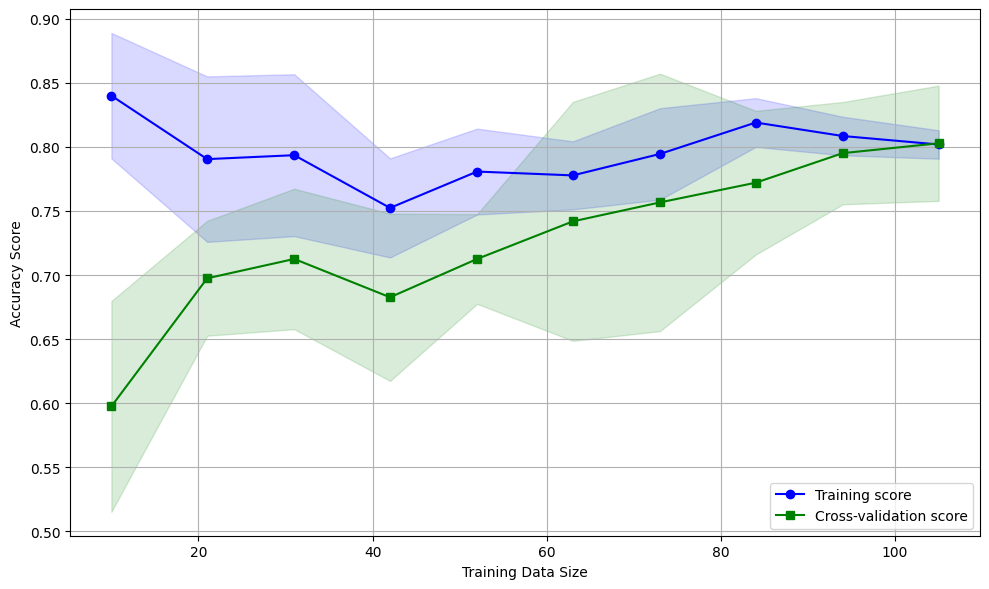

In [54]:
from sklearn.model_selection import learning_curve, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

#  'extra_trees' is the ExtraTreesClassifier model
# And 'X_top_features', 'y' are already defined

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    extra_trees, X_top_features, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
    n_jobs=-1,
    scoring='accuracy'
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.15)
plt.plot(train_sizes, test_mean, label='Cross-validation score', color='green', marker='s')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.15)

# Plot aesthetics
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

# Save the plot with the specified aesthetics
plt.savefig('charts/learning_curve.png', dpi=300, bbox_inches='tight', pad_inches=0.1, transparent=True, facecolor='white')
plt.show()


# ROC Curve, Precision-Recall Curve


In [55]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt


# X_top_features and y are already defined

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Lists to store metrics for each fold - Testing
test_accuracies = []
test_mccs = []  # Matthews correlation coefficient
test_auc_roc = []  # Area Under Curve for ROC
test_auc_pr = []  # Area Under Curve for Precision-Recall

# For ROC and PR curves plotting
mean_fpr = np.linspace(0, 1, 100)
tprs = []
precisions = []
recall_rates = []




for train_index, test_index in skf.split(X_top_features, y):
    X_fold_train, X_fold_test = X_top_features.iloc[train_index], X_top_features.iloc[test_index]
    y_fold_train, y_fold_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model
    extra_trees.fit(X_fold_train, y_fold_train)

    # Evaluate on testing data
    y_test_pred = extra_trees.predict(X_fold_test)
    y_test_pred_proba = extra_trees.predict_proba(X_fold_test)[:, 1]  # Probabilities for positive class
    
    test_accuracy = accuracy_score(y_fold_test, y_test_pred)
    test_mcc = matthews_corrcoef(y_fold_test, y_test_pred)
    
    # ROC
    fpr, tpr, thresholds = roc_curve(y_fold_test, y_test_pred_proba)
    roc_auc = auc(fpr, tpr)
    test_auc_roc.append(roc_auc)
    
    # Interpolate the TPR (True Positive Rate) for plotting
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0  # Ensure start at zero
    
    # PR
    precision, recall, _ = precision_recall_curve(y_fold_test, y_test_pred_proba)
    pr_auc = auc(recall, precision)
    test_auc_pr.append(pr_auc)
    
    # Interpolate Precision and Recall for plotting
    precisions.append(np.interp(mean_fpr, recall[::-1], precision[::-1]))
    recall_rates.append(mean_fpr)
    
    test_accuracies.append(test_accuracy)
    test_mccs.append(test_mcc)



# Create the 'inspection' directory if it doesn't exist
os.makedirs('inspection', exist_ok=True)

# Instead of plt.show(), save the figures
# Plotting ROC Curve
plt.figure(figsize=(10, 5))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f)' % (mean_auc), lw=2, alpha=.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Save the ROC Curve
roc_curve_path = 'charts/roc_curve.png'
plt.savefig(roc_curve_path, dpi=300)
plt.close()  # Close the figure

# Plotting Precision-Recall Curve
plt.figure(figsize=(10, 5))
mean_precision = np.mean(precisions, axis=0)
mean_recall = np.mean(recall_rates, axis=0)
mean_pr_auc = auc(mean_recall, mean_precision)
plt.plot(mean_recall, mean_precision, color='b', label=r'Mean PR (AUC = %0.2f)' % (mean_pr_auc), lw=2, alpha=.8)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

# Save the Precision-Recall Curve
pr_curve_path = 'charts/pr_curve.png'
plt.savefig(pr_curve_path, dpi=300)
plt.close()  # Close the figure

# Creating DataFrames to display results
test_results_df = pd.DataFrame({
    'Fold': list(range(1, 6)),
    'Accuracy': test_accuracies,
    'MCC': test_mccs,
    'AUC ROC': test_auc_roc,
    'AUC PR': test_auc_pr
})

print("\nTesting Set Metrics:")
print(test_results_df)

# After saving you can print out the path to the saved files
print(f"ROC Curve saved to: {roc_curve_path}")
print(f"Precision-Recall Curve saved to: {pr_curve_path}")



Testing Set Metrics:
   Fold  Accuracy       MCC   AUC ROC    AUC PR
0     1  0.777778  0.554945  0.851648  0.894133
1     2  0.851852  0.712718  0.947802  0.959900
2     3  0.730769  0.461563  0.779762  0.841261
3     4  0.692308  0.450051  0.860119  0.857074
4     5  0.846154  0.692308  0.917160  0.929639
ROC Curve saved to: charts/roc_curve.png
Precision-Recall Curve saved to: charts/pr_curve.png


In [62]:

import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.inspection import PartialDependenceDisplay

# extra_trees is already trained and X_top_features, y are defined

# Create a new directory called 'pdp' to save the plots if it does not exist
os.makedirs('pdp', exist_ok=True)

# Generate and save partial dependence plots for all features
for feature_index in range(X_top_features.shape[1]):
    fig, ax = plt.subplots(figsize=(8, 4))
    display = PartialDependenceDisplay.from_estimator(
        extra_trees,
        X_top_features,
        features=[feature_index],
        ax=ax,
        kind="average"
    )
    plt.subplots_adjust(top=0.9)  # Adjust layout to fit suptitle
    
    # Save the plot to the 'pdp' directory with 300 dpi resolution
    plot_path = f'pdp/pdp_feature_{feature_index}.png'
    plt.savefig(plot_path, dpi=300)
    plt.close()  # Close the plot to free up memory

# Print out a confirmation message
print("All partial dependence plots have been saved in the 'pdp' directory.")



# Create a new directory called 'pdp' to save the plots if it does not exist
os.makedirs('pdp', exist_ok=True)




# Define function to create and save collages
def create_pdp_collage(start_feature, end_feature, n_rows, n_cols, file_name):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, n_rows*3))  # Adjust figure size as necessary
    axs = axs.flatten()
    
    for idx, feature_index in enumerate(range(start_feature, end_feature)):
        PartialDependenceDisplay.from_estimator(
            extra_trees,
            X_top_features,
            features=[feature_index],
            ax=axs[idx],
            kind="average"
        )
    
    # Hide any unused subplots
    for ax in axs[end_feature - start_feature:]:
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.savefig(f'pdp/{file_name}.png', dpi=300, bbox_inches='tight')
    plt.close()

# Total number of features
total_features = X_top_features.shape[1]

# Create the first collage with two columns and four rows
create_pdp_collage(0, min(8, total_features), 4, 2, 'pdp_collage_1')

# Create the second collage with two columns and three rows for the remaining features
if total_features > 8:
    create_pdp_collage(8, total_features, 3, 2, 'pdp_collage_2')

print("All partial dependence plot collages have been saved in the 'pdp' directory.")


All partial dependence plots have been saved in the 'pdp' directory.
All partial dependence plot collages have been saved in the 'pdp' directory.


https://www.kaggle.com/code/rafjaa/dealing-with-very-small-datasets

# Inspecting Features

In [30]:
import pandas as pd
import os

# Load the data
file_path = 'aggregated_plants.csv'
df = pd.read_csv(file_path)

# List of important features from the model 
important_features = [
    'Bit_875',
    'Bit_549',
    'Bit_1607',
    'Bit_383',
    'Bit_1602',
    'Bit_1750',
    'Bit_1365',
    'Bit_1930',
    'Bit_1853',
    'Bit_1950',
    'Bit_171',
    'Bit_741',
    'Bit_1574',
    'Bit_1309'
]



save_dir = './features/' 

# Check if the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Iterating through each important feature
for feature in important_features:
    # Filter rows where the feature is present (1)
    feature_present_df = df[df[feature] == 1]
    
    # Drop all other 'Bit_' columns except the one in focus
    columns_to_drop = [col for col in df.columns if col.startswith('Bit_') and col != feature]
    feature_present_df = feature_present_df.drop(columns=columns_to_drop)
    
    # Define the new file path
    new_file_path = save_dir + f"{feature}.csv"
    
    # Save the filtered rows to a new CSV file
    feature_present_df.to_csv(new_file_path, index=False)
    
    print(f"Rows where {feature} is present and all other Bit_ columns are removed have been saved to '{new_file_path}'")


Rows where Bit_875 is present and all other Bit_ columns are removed have been saved to './features/Bit_875.csv'
Rows where Bit_549 is present and all other Bit_ columns are removed have been saved to './features/Bit_549.csv'
Rows where Bit_1607 is present and all other Bit_ columns are removed have been saved to './features/Bit_1607.csv'
Rows where Bit_383 is present and all other Bit_ columns are removed have been saved to './features/Bit_383.csv'
Rows where Bit_1602 is present and all other Bit_ columns are removed have been saved to './features/Bit_1602.csv'
Rows where Bit_1750 is present and all other Bit_ columns are removed have been saved to './features/Bit_1750.csv'
Rows where Bit_1365 is present and all other Bit_ columns are removed have been saved to './features/Bit_1365.csv'
Rows where Bit_1930 is present and all other Bit_ columns are removed have been saved to './features/Bit_1930.csv'
Rows where Bit_1853 is present and all other Bit_ columns are removed have been saved 

# Adding SMILES-Chemical pairs, Chemical names, and Concentrations


In [31]:
import pandas as pd
import os
import ast
from collections import Counter
import glob

def safe_literal_eval(s):
    dict_strings = [d.strip() for d in s.split(';') if d.strip()]
    all_dicts = {}
    for dict_str in dict_strings:
        try:
            all_dicts.update(ast.literal_eval(dict_str))
        except Exception as e:
            print(f"Failed to parse part: {dict_str}\nError: {e}")
    return all_dicts

def preprocess_bit_name(bit_name):
    bit_number = bit_name.replace('Bit_', '').replace('.csv', '')
    return int(bit_number)

features_dir = 'features/'
reorganized_plants_path = 'reorganized_plants_filtered.csv'
combined_chemicals_path = '../initial_data/combined_chemicals_smiles.csv'

reorganized_plants_df = pd.read_csv(reorganized_plants_path)
combined_chemicals_df = pd.read_csv(combined_chemicals_path)  # Load the combined chemicals data
reorganized_plants_df = reorganized_plants_df.drop_duplicates(subset=['Plant_Species', 'Chemical'])

assert 'Concentration' in reorganized_plants_df.columns, "Concentration column not found in the reorganized plants data!"

bit_files = glob.glob(os.path.join(features_dir, 'Bit_*.csv'))

for bit_file in bit_files:
    bit_name = os.path.basename(bit_file)
    bit_name = bit_name.replace('.csv', '')

    new_bit_file = os.path.join(features_dir, f"{bit_name}_updated.csv")

    bit_df = pd.read_csv(bit_file)

    bit_df['BitInterpretations'] = bit_df['BitInterpretations'].apply(safe_literal_eval)

    if 'SMILES' not in bit_df.columns:
        bit_df.insert(3, 'SMILES', '')
    if 'Chemical' not in bit_df.columns:
        bit_df.insert(4, 'Chemical', '')
    if 'Chemical_name' not in bit_df.columns:  # Add Chemical_name column 
        bit_df.insert(5, 'Chemical_name', '')

    expanded_rows = []

    for index, row in bit_df.iterrows():
        plant_species = row['Plant_Species']
        bit_interpretations = row['BitInterpretations']
        bit_number = preprocess_bit_name(bit_name)

        if bit_number in bit_interpretations:
            interpreted_bit = str(bit_interpretations[bit_number])
        else:
            interpreted_bit = ''

        matching_rows = reorganized_plants_df[
            (reorganized_plants_df['Plant_Species'].str.lower() == plant_species.lower()) &
            (reorganized_plants_df[bit_name] == 1)]

        for _, match in matching_rows.iterrows():
            new_row = row.copy()
            new_row['SMILES'] = match['SMILES']
            new_row['Chemical'] = match['Chemical']
            new_row['BitInterpretations'] = interpreted_bit
            new_row['Chemical_name'] = combined_chemicals_df[combined_chemicals_df['SMILES'] == match['SMILES']]['Chemical Name'].iloc[0]

            # Ensure matching both 'SMILES' and 'Plant_Species'
            concentration_match = reorganized_plants_df[
                (reorganized_plants_df['SMILES'] == match['SMILES']) & 
                (reorganized_plants_df['Plant_Species'].str.lower() == plant_species.lower())
            ]['Concentration']

            new_row['Concentration'] = concentration_match.iloc[0] if not concentration_match.empty else None

            expanded_rows.append(new_row)

    expanded_bit_df = pd.DataFrame(expanded_rows)

    # Remove the 'Chemical' column as it's no longer needed
    expanded_bit_df = expanded_bit_df.drop(columns=['Chemical'])

    expanded_bit_df = expanded_bit_df.sort_values(by='Chemical_name', ascending=True)

    expanded_bit_df.to_csv(new_bit_file, index=False)

    print(f"Updated {bit_name} with individual SMILES, Chemical names from combined file has been saved to {new_bit_file}")

print("All Bit files have been processed and updated with individual SMILES-Chemical pairs, Chemical names, and Concentrations.")


Updated Bit_1930 with individual SMILES, Chemical names from combined file has been saved to features/Bit_1930_updated.csv
Updated Bit_383 with individual SMILES, Chemical names from combined file has been saved to features/Bit_383_updated.csv
Updated Bit_1853 with individual SMILES, Chemical names from combined file has been saved to features/Bit_1853_updated.csv
Updated Bit_741 with individual SMILES, Chemical names from combined file has been saved to features/Bit_741_updated.csv
Updated Bit_875 with individual SMILES, Chemical names from combined file has been saved to features/Bit_875_updated.csv
Updated Bit_1365 with individual SMILES, Chemical names from combined file has been saved to features/Bit_1365_updated.csv
Updated Bit_1950 with individual SMILES, Chemical names from combined file has been saved to features/Bit_1950_updated.csv
Updated Bit_1602 with individual SMILES, Chemical names from combined file has been saved to features/Bit_1602_updated.csv
Updated Bit_1574 with 

# Visualisation of molecular features

In [32]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Draw
import os

important_features = [
    'Bit_875',
    'Bit_549',
    'Bit_1607',
    'Bit_383',
    'Bit_1602',
    'Bit_1750',
    'Bit_1365',
    'Bit_1930',
    'Bit_1853',
    'Bit_1950',
    'Bit_171',
    'Bit_741',
    'Bit_1574',
    'Bit_1309'
]

# Define the output folder for SVG images
output_folder = 'visualizations'  # Adjust as needed
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

for feature in important_features:
    bit_number = feature.split('_')[1]  # Extract the bit number from the feature name
    updated_file_path = f'features/{feature}_updated.csv'  # Construct the file path dynamically
    
    try:
        df = pd.read_csv(updated_file_path)
    except FileNotFoundError:
        print(f"File {updated_file_path} not found, skipping.")
        continue

    bit_to_visualize = int(bit_number)  # Convert the bit number to an integer

    for idx, row in df.drop_duplicates(subset='SMILES').iterrows():
        smiles = row['SMILES']
        chemical_name = row.get('Chemical_name', 'Unnamed_Chemical')  # Default name if not present
        plant_species = row.get('Plant_Species', 'UnknownSpecies').split()[:2]  # Get first two words of plant species
        concentration = row.get('Concentration', 0)  # Get concentration value, default to 0 if not present

        # Generate a molecule from the SMILES string
        mol = Chem.MolFromSmiles(smiles)
        if not mol: continue  # Skip if molecule can't be created

        # Generate a Morgan fingerprint and save information about the bits that are set
        bit_info = {}
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048, bitInfo=bit_info)

        if bit_to_visualize in bit_info:
            # Visualize the first example of the bit setting
            whichExample = 0  # Always use the first example
            img = Draw.DrawMorganBit(mol, bit_to_visualize, bit_info, whichExample=whichExample, useSVG=True)
            
            # Ensure the chemical name, plant species, and concentration are filesystem safe
            safe_chemical_name = ''.join(e for e in chemical_name if e.isalnum())
            safe_plant_species = '_'.join(''.join(e for e in word if e.isalnum()) for word in plant_species)
            safe_concentration = ''.join(e for e in str(concentration) if e.isdigit() or e == '.')  # Convert float to string

            # Filename includes the bit, chemical name, plant species, and concentration
            svg_file_path = os.path.join(output_folder, f"bit_{bit_to_visualize}_{safe_chemical_name}_{safe_plant_species}_conc_{safe_concentration}.svg")
            with open(svg_file_path, "w") as svg_file:
                svg_file.write(img.data)
            print(f"Saved SVG image to {svg_file_path}")


Saved SVG image to visualizations/bit_1873_alphaTerpineol_Fissitigma_shangtzeense_conc_0.1213.svg
Saved SVG image to visualizations/bit_1873_EAnethole_Illicium_verum_conc_0.827.svg
Saved SVG image to visualizations/bit_1873_EEthylcinnamate_Elaeagnus_angustifolia_conc_0.3279.svg
Saved SVG image to visualizations/bit_1873_EbetaOcimene_Tagetes_lucida_conc_0.138.svg
Saved SVG image to visualizations/bit_1873_EZalphaFarnesene_Lonicera_japonica_conc_0.12.svg
Saved SVG image to visualizations/bit_1873_Z3Hexenylbenzoate_Jasminum_sambac_conc_0.1.svg
Saved SVG image to visualizations/bit_1873_2Hydroxy4methoxyacetophenone_Rheum_palmatum_conc_0.162.svg
Saved SVG image to visualizations/bit_1873_2Phenylethanol_Elaeagnus_angustifolia_conc_0.0935.svg
Saved SVG image to visualizations/bit_1873_2Phenylethylisothiocyanate_Armoracia_lapathifolia_conc_0.44.svg
Saved SVG image to visualizations/bit_1873_Allyl2345tetramethoxybenzene_Petroselinum_crispum_conc_0.2594.svg
Saved SVG image to visualizations/bit_

# Plotting the correlation of top features with the target


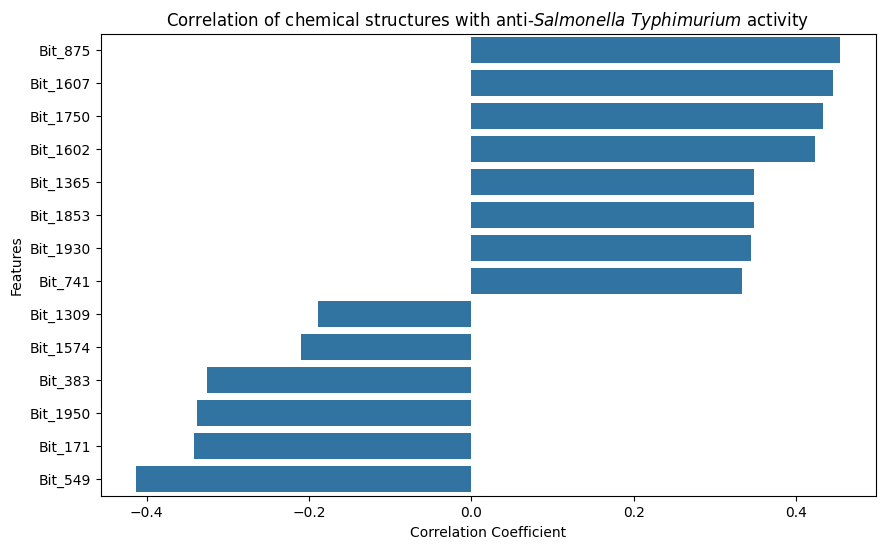

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, ExtraTreesClassifier
from sklearn.model_selection import train_test_split

#  'features_filtered', 'target_filtered', and 'indices' are already defined

# Selecting the top features for analysis
top_feature_names = features_filtered.columns[indices[:TOP_FEATURES]]

X_top_features = features_filtered[top_feature_names]
y = target_filtered

# Combine the top features and the target variable into a single DataFrame for correlation analysis
correlation_data = X_top_features.copy()
correlation_data['Target'] = y

# Calculate the correlation matrix with the target
corr_with_target = correlation_data.corr()['Target'].drop('Target').sort_values(ascending=False)

# Plotting the correlation with the target
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation of chemical structures with anti-$\it{Salmonella\ Typhimurium}$ activity')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

# Calculate the correlation matrix among top features
corr_matrix_top_features = X_top_features.corr()


In [33]:
# Export the correlation between chemical features and the target variable to a CSV file
corr_with_target.to_csv('chemical_target_correlation.csv', header=True)
print("Correlation data exported to 'chemical_target_correlation.csv'")

# Export the correlation matrix of top features to a CSV file
corr_matrix_top_features.to_csv('top_feature_correlation_matrix.csv', header=True)
print("Correlation matrix of top features exported to 'top_feature_correlation_matrix.csv'")



Correlation data exported to 'chemical_target_correlation.csv'
Correlation matrix of top features exported to 'top_feature_correlation_matrix.csv'


# After manual inspection I removed reduntant structures created due to a Morgan fingerprint hashing missmatch

In [34]:
import pandas as pd
import ast  

def get_unique_structures_info(bit_name, correlation_coefficient):
    bit_file_path = f'features/{bit_name}_updated.csv'
    unique_structures_info = {}

    try:
        bit_df = pd.read_csv(bit_file_path)
        for _, row in bit_df.iterrows():
            interpretation = row['BitInterpretations']
            try:
                interpretation_list = ast.literal_eval(interpretation)
                for item in interpretation_list:
                    if len(item) == 4:
                        structure = item[3]
                        if structure not in unique_structures_info:
                            unique_structures_info[structure] = {
                                'SMILES': row['SMILES'],
                                'Chemical_name': row['Chemical_name'],
                                'Correlation_Coefficient': correlation_coefficient
                            }
            except:
                continue
    except FileNotFoundError:
        print(f"File not found: {bit_file_path}")
    except Exception as e:
        print(f"An error occurred while processing {bit_name}: {e}")

    return unique_structures_info

# Load the chemical target correlation file
chemical_correlation_file_path = 'chemical_target_correlation.csv'
chemical_correlation_df = pd.read_csv(chemical_correlation_file_path)

# Prepare a new DataFrame for merged data
merged_data = []

for index, row in chemical_correlation_df.iterrows():
    bit_name = row.iloc[0]
    correlation_coefficient = row.iloc[1]  # Get the correlation coefficient
    structures_info = get_unique_structures_info(bit_name, correlation_coefficient)
    for structure, info in structures_info.items():
        merged_data.append({
            'Bit_name': bit_name,
            'Structure': structure,
            'SMILES': info['SMILES'],
            'Chemical_name': info['Chemical_name'],
            'Correlation_Coefficient': info['Correlation_Coefficient']
        })

# Convert the merged data into a DataFrame
merged_df = pd.DataFrame(merged_data)

# Optionally, you can save this merged DataFrame to a CSV file
merged_df.to_csv('merged_chemical_data.csv', index=False)

print(merged_df.head())  # Print the first few rows of the merged DataFrame


   Bit_name Structure                    SMILES  \
0   Bit_875       ccc  CC(=O)C1=C(C=C(C=C1)OC)O   
1  Bit_1607    cc(c)O  CC(=O)C1=C(C=C(C=C1)OC)O   
2  Bit_1750       ccc        COc1ccc(\C=C\C)cc1   
3  Bit_1602        cO  CC(=O)C1=C(C=C(C=C1)OC)O   
4  Bit_1602        CO    CC(C)C1CCC(C)=C(O)C1=O   

                      Chemical_name  Correlation_Coefficient  
0  2-Hydroxy-4-methoxy-acetophenone                 0.454575  
1  2-Hydroxy-4-methoxy-acetophenone                 0.445048  
2                      (E)-Anethole                 0.433490  
3  2-Hydroxy-4-methoxy-acetophenone                 0.422843  
4                        Diosphenol                 0.422843  
